In [ ]:
#CODE TO BE TRAINED ON IMAGES. 24X24 PIXELS what is going on
import pandas as pd
import numpy as np
import nnfs
from nnfs.datasets import spiral_data
import copy
nnfs.init()

layer_1 = 128 #number of neurons in the first layer
layer_2 = 64 #number of neurons in the second layer

# Dense layer
class Layers_Dense:

    #initializes the weights and biases
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons) #initializes random weights for teh layer, .01 to keep them small

        self.bias = np.zeros((1, n_neurons)) # initializes the biases to 0
        
    # does the dot product of the inputs and weights, and adds the bias to the output.
    # this does the inital prediction which is then used to calculate loss and what needs to be changed in the weights and biases.
    def forward(self, x):
        self.inputs = x #stores the inputs for the backwards pass (optimization step)

        self.output = np.dot(x, self.weights) + self.bias #calculates teh dot product for the next layer, and adds the bias to the output.

    # this is the backpropagation step, which gets the gradients of the weights, biases, and inputs.
    # this is used to update the weights and biases in the optimizer step.
    def backward(self, dvalues):
        #basically it helps show what happened to the inputs during the forward pass, and how they affect the output.
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

# ReLU activation
class Activation_ReLU:
    def forward(self, x):
        self.inputs = x
        self.output = np.maximum(0, x)
        # applies the ReLU activation function, which sets all negative values to zero. and all the positive values remain unchanged.
        #thisd gives more control over the neurons which increases accuracy over a linear function (helps with nonlinear data and solutions)

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0
        # during backpropagation, it sets the gradients to zero for inputs that were negative (since ReLU outputs zero for those inputs).
        #this ensures that the gradients are only propagated back through neurons that were active (i.e., had positive inputs).


# Softmax activation
class Activation_Softmax:
    def forward(self, x):
        exp_values = np.exp(x - np.max(x, axis=1, keepdims=True)) # subtracts the max value for numerical stability
        # this prevents overflow when calculating the exponential of large values.
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True) # gets the probabilities by dividing the exponentials by their sum
        # stores the probabilities in the output attribute for later use (e.g., during loss calculation).
        # This ensures that the output probabilities sum to 1 for each sample, making it suitable
        self.output = probabilities
        # applies the softmax activation function, which converts raw scores (logits) into probabilities that sum to 1 for each sample

# Cross-entropy loss
class Loss:
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss
    # This method calculates the loss by first computing the sample losses using the forward method and then averaging them to get the overall data loss.
    #this is useful during the training process to see if the changes are positive or negative. 

class Loss_CategoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred) # gets the number of samples in the predictions
        # This is used to calculate the loss for each sample in the batch.
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7) # subtracts the max value for numerical stability
        # This prevents overflow when calculating the exponential of large values.
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods
    # This method calculates the categorical cross-entropy loss between the predicted probabilities (y_pred) and the true labels (y_true).
    # basically it uses the log function to exxagerate the loss when its wrong, and maintain a reasonable answer when its right. 
    # so the difference between 70& wrong and 50% wrong is a lot more than 50% wrong ant 30% wrong.

# Adam optimizer
class Optimizer_Adam:
    def __init__(self, learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.iterations = 0
        # This initializes the Adam optimizer with parameters for learning rate, momentum coefficients (beta_1 and beta_2), 
        # and a small constant (epsilon) to prevent division by zero.

    def update_params(self, layer):
        #initializes the memomentum and cache for weights and biases if they don't exist
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.bias)
            layer.bias_cache = np.zeros_like(layer.bias)

        # Update momentum with current gradients
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + \
                                 (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + \
                               (1 - self.beta_1) * layer.dbiases

        # Corrected momentums
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

        # Update cache
        layer.weight_cache = self.beta_2 * layer.weight_cache + \
                             (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + \
                           (1 - self.beta_2) * layer.dbiases**2

        # Corrected cache
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        # Parameter update
        layer.weights -= self.learning_rate * weight_momentums_corrected / \
                         (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.bias -= self.learning_rate * bias_momentums_corrected / \
                      (np.sqrt(bias_cache_corrected) + self.epsilon)

    def pre_update_params(self):
        pass

    def post_update_params(self):
        self.iterations += 1

data = pd.read_csv('mnist dataset/mnist_train.csv')
# Create dataset X is the data, y is the labels
X = data.iloc[:, 1:].values / 255.0  # Normalize pixel values 0-255
# X is the data, which is the pixel values of the images normalized to a range of 0 to 1.
# Each row in X represents a flattened image, so a 28x28 pixel image becomes
y = data.iloc[:, 0].values  # number labels, 0-9

# Create model
#the first layer is (number of inputs, number of neurons in the layer)
dense1 = Layers_Dense(784, layer_1)#  # 784 inputs for a 28x28 pixel image flattened into a single row
activation1 = Activation_ReLU()

#the second layer is (previous layer's neurons, number of neurons in the layer)
dense_hidden = Layers_Dense(layer_1, layer_2) #layer inbetween the first and second
activation_hidden = Activation_ReLU()     # ReLU activation

#the third layer is (previous layer's neurons, number of outputs)
dense2 = Layers_Dense(layer_2, 10)  # 10 outputs for digits 0-9
activation2 = Activation_Softmax()
loss_function = Loss_CategoricalCrossentropy()
optimizer = Optimizer_Adam(learning_rate=0.001)

patience = 250  # Stop if no improvement after 250 epochs
epochs_without_improvement = 0
best_accuracy = 0
best_weights = {}

max_epochs = 2001

for epoch in range(max_epochs):
    # --- Forward pass ---
    dense1.forward(X)
    activation1.forward(dense1.output)

    dense_hidden.forward(activation1.output)
    activation_hidden.forward(dense_hidden.output)

    dense2.forward(activation_hidden.output)
    activation2.forward(dense2.output)

    # --- Loss and accuracy ---
    loss = loss_function.calculate(activation2.output, y)
    predictions = np.argmax(activation2.output, axis=1)
    accuracy = np.mean(predictions == y)

    # --- Check for improvement ---
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_weights = {
            'dense1': copy.deepcopy(dense1),
            'dense_hidden': copy.deepcopy(dense_hidden),
            'dense2': copy.deepcopy(dense2)
        }
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    # --- Backward pass ---
    dvalues = activation2.output.copy()
    dvalues[range(len(y)), y] -= 1
    dvalues /= len(y)

    dense2.backward(dvalues)
    activation_hidden.backward(dense2.dinputs)
    dense_hidden.backward(activation_hidden.dinputs)
    activation1.backward(dense_hidden.dinputs)
    dense1.backward(activation1.dinputs)

    # --- Update weights and biases ---
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense_hidden)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

    # --- Logging ---
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Best Accuracy: {best_accuracy:.4f}")

    # --- Early stopping check ---
    if epochs_without_improvement >= patience:
        print(f"Stopping early at epoch {epoch}. No improvement for {patience} epochs.")
        break

# Restore best weights
dense1 = best_weights['dense1']
dense_hidden = best_weights['dense_hidden']
dense2 = best_weights['dense2']

print(f"Training complete. Best accuracy: {best_accuracy:.4f}")


Epoch 0, Loss: 2.3025, Accuracy: 0.1121, Best Accuracy: 0.1121
Epoch 10, Loss: 2.2452, Accuracy: 0.5520, Best Accuracy: 0.5651
Epoch 20, Loss: 1.9026, Accuracy: 0.4548, Best Accuracy: 0.5651
Epoch 30, Loss: 1.3356, Accuracy: 0.5944, Best Accuracy: 0.5944
Epoch 40, Loss: 0.9413, Accuracy: 0.7047, Best Accuracy: 0.7047
Epoch 50, Loss: 0.7156, Accuracy: 0.7732, Best Accuracy: 0.7732
Epoch 60, Loss: 0.5781, Accuracy: 0.8246, Best Accuracy: 0.8246
Epoch 70, Loss: 0.4869, Accuracy: 0.8553, Best Accuracy: 0.8553
Epoch 80, Loss: 0.4233, Accuracy: 0.8755, Best Accuracy: 0.8755
Epoch 90, Loss: 0.3790, Accuracy: 0.8900, Best Accuracy: 0.8900
Epoch 100, Loss: 0.3482, Accuracy: 0.9001, Best Accuracy: 0.9001
Epoch 110, Loss: 0.3242, Accuracy: 0.9075, Best Accuracy: 0.9075
Epoch 120, Loss: 0.3046, Accuracy: 0.9137, Best Accuracy: 0.9137
Epoch 130, Loss: 0.2880, Accuracy: 0.9181, Best Accuracy: 0.9181
Epoch 140, Loss: 0.2737, Accuracy: 0.9221, Best Accuracy: 0.9221
Epoch 150, Loss: 0.2607, Accuracy: 0

In [3]:
#Save the model to disk
import numpy as np

np.savez('best_model_weights.npz',
         dense1_weights=dense1.weights,
         dense1_bias=dense1.bias,
         dense_hidden_weights=dense_hidden.weights,
         dense_hidden_bias=dense_hidden.bias,
         dense2_weights=dense2.weights,
         dense2_bias=dense2.bias)

print("Model weights saved to best_model_weights.npz")


Model weights saved to best_model_weights.npz


Model Accuracy on MNIST Training Data: 100.00%

First 10 Predictions vs Actual Labels:


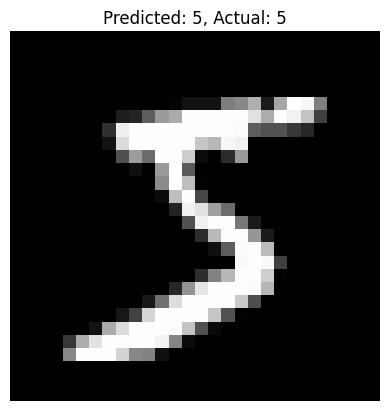

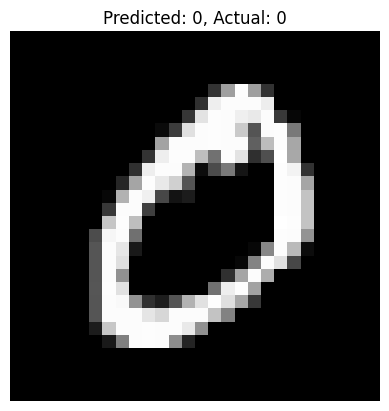

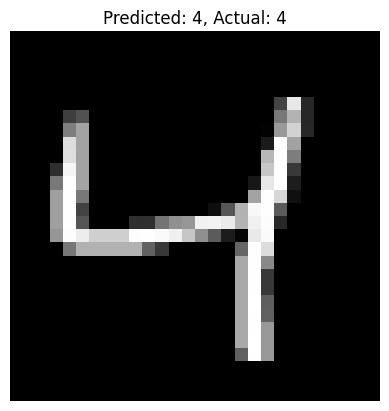

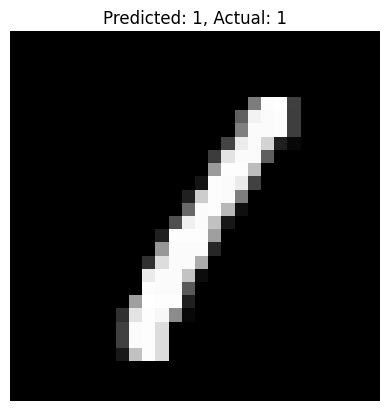

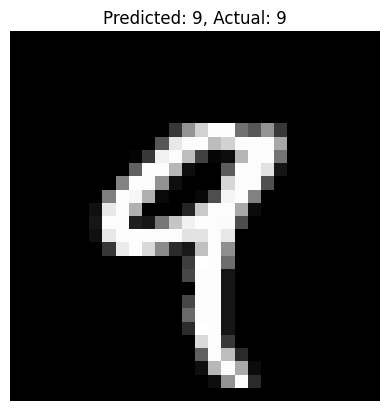

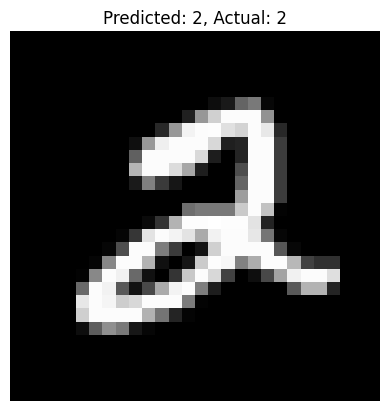

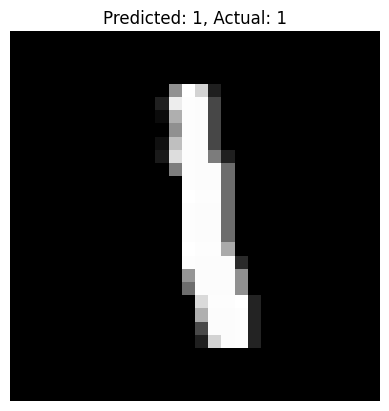

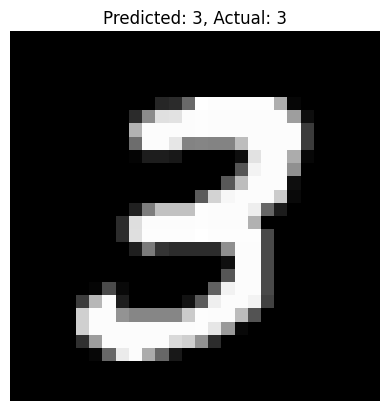

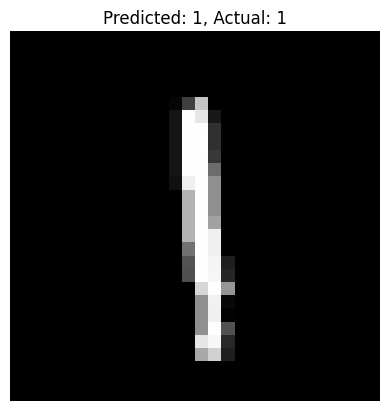

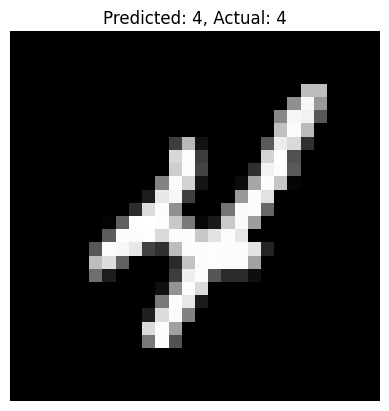


Found 0 incorrect predictions. Displaying first 25:


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----- Load the dataset -----
data = pd.read_csv('mnist dataset/mnist_train.csv')
X = data.iloc[:, 1:].values / 255.0  # normalize pixel values
y_true = data.iloc[:, 0].values

# ----- Define network components -----
class Layers_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = None
        self.bias = None

    def forward(self, x):
        self.inputs = x
        self.output = np.dot(x, self.weights) + self.bias

class Activation_ReLU:
    def forward(self, x):
        self.inputs = x
        self.output = np.maximum(0, x)

class Activation_Softmax:
    def forward(self, x):
        exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities

# ----- Load the best weights -----
weights = np.load('best_model_weights.npz', allow_pickle=True)

dense1 = Layers_Dense(784, 64)
dense1.weights = weights['dense1_weights']
dense1.bias = weights['dense1_bias']

dense_hidden = Layers_Dense(64, 64)
dense_hidden.weights = weights['dense_hidden_weights']
dense_hidden.bias = weights['dense_hidden_bias']

dense2 = Layers_Dense(64, 10)
dense2.weights = weights['dense2_weights']
dense2.bias = weights['dense2_bias']

activation1 = Activation_ReLU()
activation_hidden = Activation_ReLU()
activation2 = Activation_Softmax()

# ----- Run forward pass -----
dense1.forward(X)
activation1.forward(dense1.output)

dense_hidden.forward(activation1.output)
activation_hidden.forward(dense_hidden.output)

dense2.forward(activation_hidden.output)
activation2.forward(dense2.output)

predictions = np.argmax(activation2.output, axis=1)
accuracy = np.mean(predictions == y_true)
print(f"Model Accuracy on MNIST Training Data: {accuracy * 100:.2f}%")

# ----- Display first 10 predictions -----
print("\nFirst 10 Predictions vs Actual Labels:")
for i in range(10):
    plt.imshow(X[i].reshape(28,28), cmap='gray')
    plt.title(f"Predicted: {predictions[i]}, Actual: {y_true[i]}")
    plt.axis('off')
    plt.show()

# ----- Display 25 incorrect predictions -----
incorrect_indices = np.where(predictions != y_true)[0]
print(f"\nFound {len(incorrect_indices)} incorrect predictions. Displaying first 25:")

for i, idx in enumerate(incorrect_indices[:25]):
    plt.imshow(X[idx].reshape(28,28), cmap='gray')
    plt.title(f"Incorrect - Predicted: {predictions[idx]}, Actual: {y_true[idx]}")
    plt.axis('off')
    plt.show()
